# **First Guess in Wordle?**

#### Author: Sai Akhil Siruguppa

## Introduction

Have you ever played a game of Wordle and wondered 'Hmm, so what should my first word be so that I have the best chance of getting this one right?'. Well I had the same thought in my head and I started crunching some numbers (and letters) to find an answer to this question. Though there's no right answer, there definitely is a best one! For anyone who is reading this for the first time, Wordle is a simple word game where you have 6 chances to guess the word right. The rules are simple and the website (https://www.nytimes.com/games/wordle/index.html) explains them well:

<img src="images/rules.png" style="width: 500px;"/>

So by the end of this notebook, we should be able to understand with some certainity what should be the best first word to the start the game with. So read on!

## Exploratory Data Analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_guesses = pd.read_csv('data/valid_guesses.csv')
for i in range(5):
    df_guesses[i] = df_guesses['word'].str[i]

In [3]:
df_solutions = pd.read_csv('data/valid_solutions.csv')
for i in range(5):
    df_solutions[i] = df_solutions['word'].str[i]

To understand the words better, we will first calculate the frequency of the letters in the solutions dataset. This can help us understand the the specific frequency of the letters in each of the position namely 0, 1, 2, 3, 4. Furthermore we can understand the top occurring or most probable letter across the word in the entire corpus of solution words present.

In [4]:
# Calculate frequency of solution words
df_freq_solutions = pd.DataFrame()
for i in range(5):
    df_temp = pd.DataFrame(df_solutions[i].value_counts().sort_index())
    df_freq_solutions = pd.concat([df_freq_solutions, df_temp], axis=1)
df_freq_solutions = df_freq_solutions.fillna(0)

In [5]:
df_freq_solutions['total'] = df_freq_solutions.apply(sum, axis=1)
df_freq_solutions = df_freq_solutions/df_freq_solutions.sum()

### How frequent is a letter at every position in a 5 letter word?

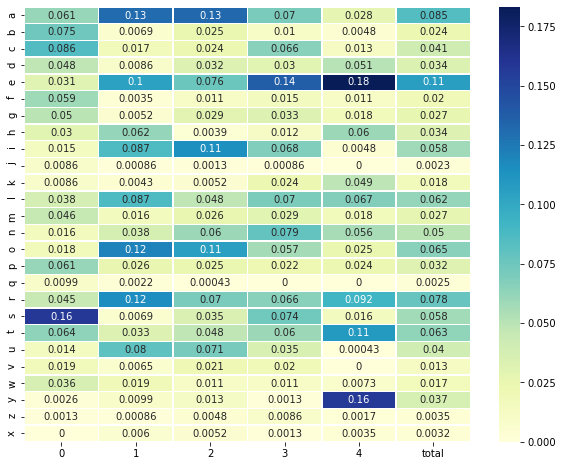

In [6]:
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(df_freq_solutions, linewidths=0.5, cmap="YlGnBu", annot=True)

We can see from the above heatmap that the letters are definitely not evenly distributed and certainly some letters are more frequently occuring in specific positions than others. Lets further take a look at each position closely.

### What are the 5 most frequently occuring letters at each position in a 5 letter word?

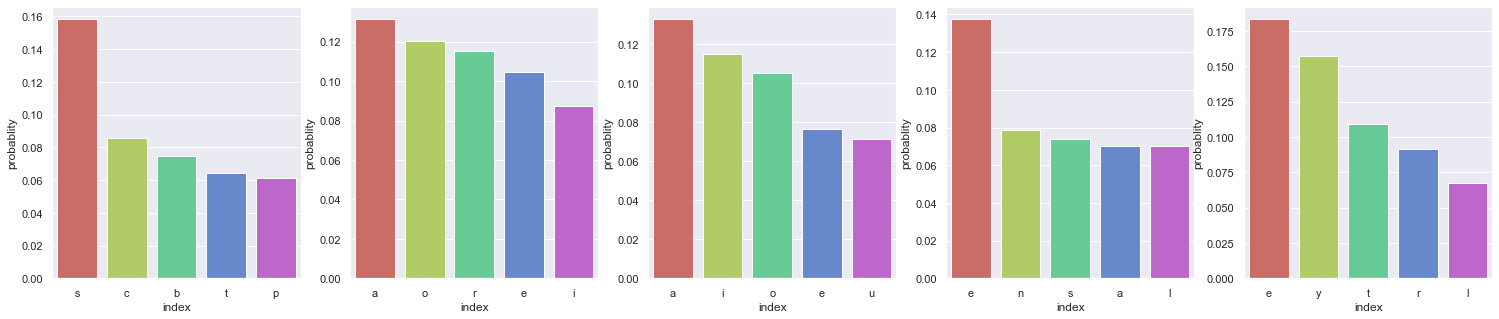

In [7]:
sns.set(style="darkgrid")
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5,figsize=(20,5))
plt.subplots_adjust(left=6, right=7)

mylist = [ax0, ax1, ax2, ax3, ax4]
for i in range(5):
    largest_five = pd.DataFrame(df_freq_solutions[i].nlargest(5)).rename(columns={i: 'probablity'}).reset_index()
    sns.barplot(data = largest_five, x = 'index', y='probablity', ax=mylist[i], palette='hls')

We can see from the above that:
- **s** is by far the most frequent letter in the **first** position followed by **c, b, t, p**
- **a** is the most frequent letter in the **second** position closely followed by **o**. They are followed by **r, e, i** respectively.
- **a** is the most frequent letter in the **third** position and is followed by **i, o, e, u**
- **e** is by far the most frequent letter in the **fourth** position followed by **n, s, a, l**
- **e** is again the most frequent letter in the **first** position followed by **y, t, r, l**

### How frequent is a letter to occur anywhere across a 5 letter word?

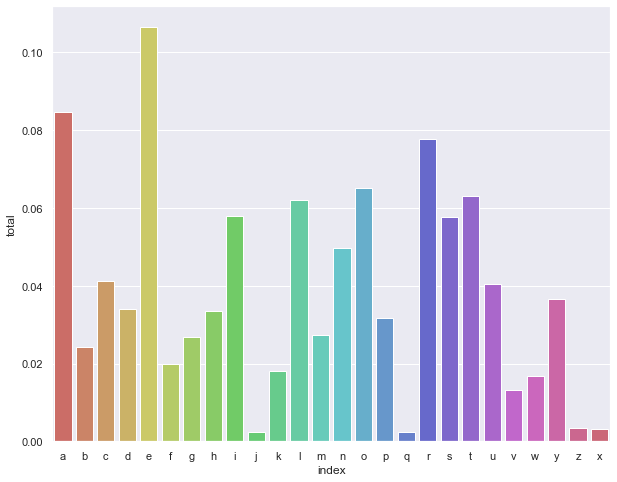

In [8]:
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.barplot(
    data = pd.DataFrame(df_freq_solutions['total']).reset_index(), x = 'index', y='total', palette='hls')

Here, we are looking at how frequently a letter is occuring across a word. 
- We can see that **e** is the most frequent letter in a 5 letter word and occurs with a probabilty of **0.11**. This is followed by the letter **a** which has a probabilty to occur slightly greater than **0.08**. At third place we have the letter **r** with a probability slightly lesser than **0.08**.
- We can also see that the least frequently occuring letters in a 5 letter word are **j, q, z, x**

### Filtering out Words with Duplicate letters

In [9]:
df_guesses.head()

,word,0,1,2,3,4
0,aahed,a,a,h,e,d
1,aalii,a,a,l,i,i
2,aargh,a,a,r,g,h
3,aarti,a,a,r,t,i
4,abaca,a,b,a,c,a


Since our primary goal is to get the best first word possible, we want to have the maximum unique characters possible so that we can reduce the search space from the second guess onwards. So in this case, when a player is trying to guessthe first word it is the most likely that she will go with a word with no duplicates. Hence, we can further reduce our search space in the guesses dataset to the words with all 5 unique characters.

In [10]:
def check_unique(x):
    """Function to check if all the characters in a word are unique"""
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            if (x[i] == x[j]):
                return False
    return True

In [11]:
df_guesses['unique'] = df_guesses['word'].apply(check_unique)

In [12]:
df_guesses.head()

,word,0,1,2,3,4,unique
0,aahed,a,a,h,e,d,False
1,aalii,a,a,l,i,i,False
2,aargh,a,a,r,g,h,False
3,aarti,a,a,r,t,i,False
4,abaca,a,b,a,c,a,False


In [13]:
df_guesses = df_guesses[df_guesses['unique'] == True]
len(df_guesses)

6756

## Maximum Entropy Prioritization

**What is entropy?**    

Entropy measures the expected amount of information conveyed by identifying the outcome of a random trial. In information theory, the entropy of a random variable is the average level of “information“, “surprise”, or “uncertainty” inherent in the variable’s possible outcomes.

In our case we can see that for every position in a 5 letter word we have 3 possibilities i.e. green (correct letter and position), yellow (correct letter and wrong postion) and black (wrong letter and wrong position). This means that we have a total of $ 3^5 = 243 $ possibilities.

For every word in our guesses dataset, we can determine where it belongs in the 243 possibilities we have. Using this information we can calculate the probability for every outcome and hence the entropy. Our aim is to reduce the "uncertainity" as much as possible and hence the word with the maximum entropy would be our optimum solution

In [14]:
entropy = [0]*(len(df_guesses))

In [15]:
for ind, guess in enumerate(df_guesses['word']):
    arr = np.zeros(shape=(3,3,3,3,3), dtype=float, order='F')
    for solution in df_solutions['word']:
        index_arr = []
        for i in range(5):
            if (guess[i] == solution[i]):
                index_arr.append(0)
            elif (guess[i] in solution):
                index_arr.append(1)
            else:
                index_arr.append(2)
        arr[index_arr[0]][index_arr[1]][index_arr[2]][index_arr[3]][index_arr[4]] += 1
    arr = arr/len(df_solutions)
    for p in arr.flatten():
        if (p != 0):
            entropy[ind] = entropy[ind] + (-p*np.log(p))

In [16]:
df_guesses['entropy'] = entropy

## Final Results

In [17]:
df_guesses.sort_values(by='entropy', ascending=False)

,word,0,1,2,3,4,unique,entropy
8530,soare,s,o,a,r,e,True,4.079837
7642,roate,r,o,a,t,e,True,4.077632
7320,raile,r,a,i,l,e,True,4.065800
7424,reast,r,e,a,s,t,True,4.065625
7868,salet,s,a,l,e,t,True,4.044224
...,...,...,...,...,...,...,...,...
8752,squiz,s,q,u,i,z,True,2.219255
4567,junky,j,u,n,k,y,True,2.192689
4553,judgy,j,u,d,g,y,True,2.170608
10019,vozhd,v,o,z,h,d,True,2.166648


### Top 10 words to start your game in Wordle

Now that we have calculated the entropy for all the words in the guesses dataset, lets take a look at the top 10 words that would prioritize maximum entropy.

In [18]:
df_final = pd.DataFrame(df_guesses[['word', 'entropy']].sort_values(by='entropy', ascending=False).head(10)).reset_index()

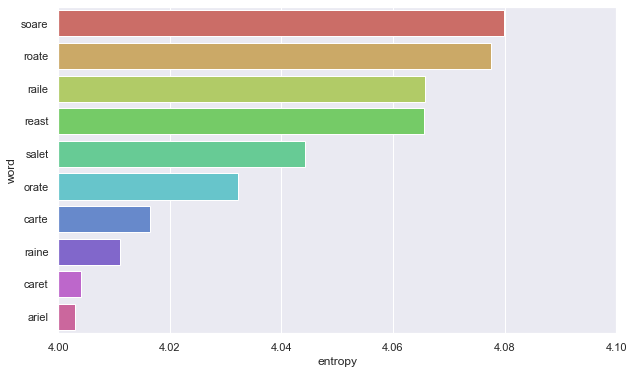

In [19]:
f, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(4, 4.1))
ax = sns.barplot(
    data = df_final, x='entropy', y = 'word', palette='hls')

### Worst 10 words to start your game in Wordle

Also, while we are at it. Let's also look at what are the worst 10 words to start your game with!

In [20]:
df_final = pd.DataFrame(df_guesses[['word', 'entropy']].sort_values(by='entropy', ascending=True).head(10)).reset_index()

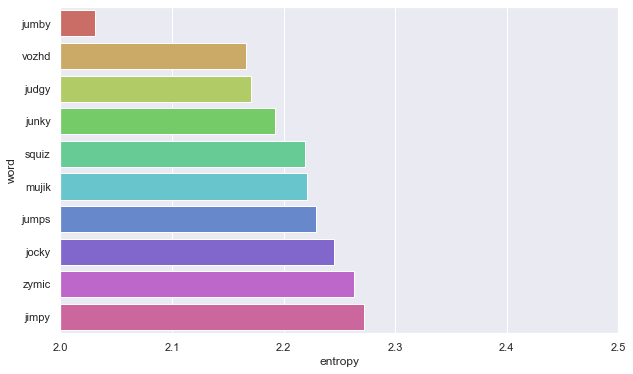

In [21]:
f, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(2, 2.5))
ax = sns.barplot(
    data = df_final, x='entropy', y = 'word', palette='hls')

So now we have it! We can see that **soare** would be the best word for anyone to start their game. Also, if you find someone starting their game with **jumby**, make sure to warn them that they don't do it!

<img src='images/giphy.gif'>